In [1]:
import os
import sys
import json
import subprocess
import shutil
import random
import re

if 'SUMO_HOME' in os.environ:
    sys.path.append(os.path.join(os.environ['SUMO_HOME'], 'tools'))
import sumolib
import importlib
from pprint import pprint
import pandas as pd
import xml.etree.ElementTree as ET
import numpy as np

# Add the "scripts" directory to sys.path
current_dir = os.path.dirname(os.path.abspath("__file__"))
scripts_dir = os.path.abspath(os.path.join(current_dir, 'scripts'))
sys.path.append(scripts_dir)
import vehParameters
import osmAPI as osm
import LLAMAconnect

FOLDER_NAME = "unicamp"

### Defining paths and setting up osm.sumocfg file

In [2]:
def add_xml_child(file_path, parent_tag, child_tag, child_value):
    """
    Adds a new child parameter inside a specified parent tag in the XML configuration file.
    If the parent tag does not exist, it creates a new parent tag (<parameter>) with the child.
    It also checks if the child element already exists to prevent duplicates.

    Args:
        file_path (str): Path to the XML configuration file.
        parent_tag (str): The parent tag under which to add the child (e.g., 'input').
        child_tag (str): The child tag to add (e.g., 'additional-files').
        child_value (str): The value to set for the new child tag.

    Returns:
        bool: True if the addition was successful, False otherwise.
    """
    try:
        # Parse the XML file
        tree = ET.parse(file_path)
        root = tree.getroot()

        # Find the parent element by tag
        parent_elem = root.find(parent_tag)
        if parent_elem is None:
            print(f"Parent tag '{parent_tag}' not found. Creating new parent tag.")
            parent_elem = ET.Element(parent_tag)
            root.append(parent_elem)
            print(f"Created new parent tag <{parent_tag}>.")

        # Check if the child element already exists inside the parent element
        existing_child = parent_elem.find(child_tag)
        if existing_child is not None: 
            
            if existing_child.get('value') == child_value:
                print(f"Child <{child_tag}> with value '{child_value}' already exists. Skipping addition.")
                return False
            else:
                print(f"Child <{child_tag}> already exists. Updating value to '{child_value}'.")
                existing_child.set('value', child_value)
                tree.write(file_path, encoding="UTF-8", xml_declaration=True, method="xml")
                print("XML file updated successfully.")
                return True

        # Create the new child element and set its value
        new_child = ET.Element(child_tag)
        new_child.set('value', child_value)
        print(f"Created <{child_tag}> with value '{child_value}'.")

        # Add the new child to the parent element
        parent_elem.append(new_child)
        print(f"Added <{child_tag}> to <{parent_tag}>.")

        # Write the updated XML to the file
        tree.write(file_path, encoding="UTF-8", xml_declaration=True, method="xml")
        print("XML file updated successfully.")
        return True

    except ET.ParseError as e:
        print(f"XML Parsing error: {e}")
        return False
    except Exception as e:
        print(f"An error occurred: {e}")
        return False

In [117]:
NET_PATH = f'{FOLDER_NAME}/osm.net.xml'
ADDITONALS_PATH = f'{FOLDER_NAME}/park.add.xml'
SUMOCFG_PATH = f'{FOLDER_NAME}/osm.sumocfg'
PA_REROUTER_PATH = f'{FOLDER_NAME}/pa_rerouter.xml'

# Setting up additional files
add_xml_child(SUMOCFG_PATH, 'input', 'additional-files', "park.add.xml, pa_rerouter.xml")

# Setting up time to teleport as 
# -1 (never teleport): Vehicles will never teleport, but this could cause deadlock.
# >0 (seconds): Vehicles will teleport after the specified time if they are not able to reach their destination.
time_to_teleport = 100
add_xml_child(SUMOCFG_PATH, 'processing', 'time-to-teleport', f'{time_to_teleport}')

# Adding lateral resolution to use SubLane model
lateral_resolution = 0.8
add_xml_child(SUMOCFG_PATH, 'parameters', 'lateral-resolution', f'{lateral_resolution}')

# Setting up the timestep (default is 1 second), this does not affect the simulation speed but the resolution of the simulation. A smaller timestep will result in a more accurate simulation
step_length = 1
add_xml_child(SUMOCFG_PATH, 'time', 'step-length', f'{step_length}')

# Setting up the simulation duration. To simulate 24 hours, we set the end time to (3600 steps * 24 hours) / step_lenght.
end_time = (3600 * 24) / step_length
add_xml_child(SUMOCFG_PATH, 'time', 'end', f'{end_time}')

net = sumolib.net.readNet(NET_PATH)
parkingAreas = list(sumolib.output.parse(ADDITONALS_PATH, "parkingArea"))

Child <additional-files> with value 'park.add.xml, pa_rerouter.xml' already exists. Skipping addition.
Child <time-to-teleport> with value '100' already exists. Skipping addition.
Child <lateral-resolution> with value '0.8' already exists. Skipping addition.
Child <step-length> with value '1' already exists. Skipping addition.
Child <end> with value '86400.0' already exists. Skipping addition.


# Routines

In [4]:
def flush_print():
    sys.stdout.write("\r")  # Move the cursor to the beginning of the line
    sys.stdout.write(" " * 50)  # Overwrite with spaces to clear the line
    sys.stdout.write("\r")  # Move back to the beginning again

In [5]:
def has_parking_spot(lanes, parkingAreas):
    # Example of parkingArea:
    # <parkingArea id="pa-1046248579#0" lane="-1046248579#0_0" roadsideCapacity="94" length="5.00"/>
    # Returns parkingArea id if there is a parking spot in the lane
    lane_ids = [lane.getID() for lane in lanes]
    for park in parkingAreas:
        if park.lane in lane_ids:
            return park.id
    return False

In [6]:
def getClosestEdges(lat, lon, radius, maxEdges=10):
    # Gets the 10 closest edges to the given lat, lon
    x, y = net.convertLonLat2XY(lon, lat)
    edges = net.getNeighboringEdges(x, y, radius)
    closestEdges = []
    if (len(edges) > 0):
        distanceAndEdges = sorted([(dist, edge) for edge, dist in edges], key=lambda x:x[0])

        ## Checking if the edge found can be used by passenger car
        for dist, edge in distanceAndEdges:
            if edge.allows('passenger'):
                closestEdges.append(edge)

    if len(edges) == 0:
        print(f'No edges found for {lat}, {lon}. Perhaps location is not inside the network or there are no viable roads inside the radius.')
        return None
    
    return closestEdges

In [7]:
def getParkingSpot(lat, lon, radius, parkingAreas):
    # Get the parking spot closest to the given lat, lon
    # Used to set stops for the vehicles

    edges = getClosestEdges(lat, lon, radius)
    # Look for parking spots
    for i in range(len(edges)):
        parking_spot = has_parking_spot(edges[i].getLanes(), parkingAreas)
        if parking_spot:
            return parking_spot
    print(f"No parking spot found close to {lat}, {lon}. Perhaps decrease the radius?")
    return None

In [121]:
def getPath(location_time_list, parkingAreas, steps_per_stop, radius = 100):
    # All that is needed to create the trip are the stops (parking areas) and the start and end edges.
    # The duarouter is responsible for finding the path between the edges going through the stops.
    # Here, we get the edges and stops that are going to be sent to LLAMA to create the trip.

    # 'coordinates' is a list of tuples with the latitude and longitude of the points of interest, for example IC, FEEC, IC means that
    # the vehicle will start from IC, stop at a parking lot close to FEEC, and then back to IC.
    # The first and last coordinates should be edges and the others should be parking spots.
    # `steps_per_stop` is the number of simulation steps that the vehicle will stay at each stop.

    # Departure for 7 is 0, 8 is 100, 9 is 200 and so on
    stop_durations = []
    departures = list(location_time_list.keys())
    stop_durations.append(-1) # Indicates this is an edge and not a parking spot

    path = []
    coords = [location_time_list[k]['coords'] for k in location_time_list.keys()]
    home = getClosestEdges(*coords[0], radius)[0].getID()
    path.append(home)
    
    for i in range(1, len(coords)-1):
        stop_durations.append(steps_per_stop * (departures[i] - departures[i - 1]))
        ps = getParkingSpot(*coords[i], radius, parkingAreas)
        if ps is not None:
            path.append(ps)
        else:
            print(f"Could not find parking spot for {coords[i]}")
            raise Exception(f"Could not find parking spot for {coords[i]}")

    path.append(home)
    stop_durations.append(-1)
    
    return path, stop_durations

In [9]:
def clean_response(institutes):
    cleaned_institutes = []
    for institute in institutes:
        # Remove parenthesis and everything after it
        institute = re.sub(r'\(.*', '', institute).strip()
        
        # Split by hyphen and take the longest slice
        parts = institute.split('-')
        longest_part = max(parts, key=len).strip()
        # Split by '/' and add both parts to the cleaned_institutes list
        if '/' in longest_part:
            parts = longest_part.split('/')
            for part in parts:
                part = part.strip()
                if part not in cleaned_institutes:
                    cleaned_institutes.append(part)
        else:
            if longest_part not in cleaned_institutes:
                cleaned_institutes.append(longest_part)
        
    return cleaned_institutes

### Gathering important places in the university

In [159]:
# IMPORTANT: You can try to automatically get the Institutes and Colleges from the OSM API, but this is not guaranteed to work. Sometimes buildings are not tagged and sometimes their names are not what you expect.
importlib.reload(osm)
uni_center_lat, uni_center_lon = -22.817064335298422, -47.069476596144476
uni_radius = 2000
filters = ['Instituto', 'Faculdade', 'Ciclo', 'Ginásio', 'Museu'] # Only buildings with these words in the name will be considered (use this wisely to get the desired buildings, because the API retrieves all buildings that are marked as colleges or university buildings)

resp = osm.find_nearby_university_buildings(uni_center_lat, uni_center_lon, uni_radius, filters)
institutes = [i['name'] for i in resp]

print(len(institutes), institutes)
institutes = clean_response(institutes) # Clean the names of the institutes, removing any acronyms or parenthesis that may be present
print(len(institutes), institutes) # Sometimes the API returns the same building with different names, so this is a way to reduce the number of duplicates

24 ['Ciclo Básico II', 'IC - Instituto de Computação', 'GMU - Ginásio Multidisciplinar', 'Instituto de Filosofia e Ciências Humanas - Pós Graduação', 'Faculdade de Engenharia Civil', 'Instituto de Geociências', 'Faculdade de Engenharia Elétrica e de Computação', 'FCM - Faculdade de Ciências Médicas', 'Instituto de Economia (Pavilhão de Pós-Graduação', 'Faculdade de Ciências Farmacêuticas', 'Instituto de Economia (Pavilhão administrativo)', 'Instituto de Economia (Biblioteca - Centro de Documentação Lucas Gamboa)', 'Instituto de Economia (Pavilhão de Graduação)', 'Centro Acadêmico do Instituto de Economia', 'Instituto de Biologia', 'Instituto de Física Gleb Wataghin', 'Instituto de Estudos da Linguagem', 'Instituto de Química', 'FENF - Faculdade de Enfermagem', 'IA - Instituto de Artes', 'FE - Faculdade de Educação', 'FEAGRI - Faculdade de Engenharia Agrícola', 'Museu Exploratório de Ciências', 'Ciclo Básico I']
21 ['Ciclo Básico II', 'Instituto de Computação', 'Ginásio Multidisciplinar

### Generating routines via LLM

In [160]:
# It is important not to use short names of institutes, like IB for institute of biology, because the LLM will not be able to assign the students to the correct institute.
# Note that the places have to be tags for the OSM API. The tags are used to filter the buildings that are returned by the API.
places ={
    'leisure': ["bar", "mall", "library", "park", "garden"],
    # 'eating': ["restaurant", "cafe"],
    'eating': ["Restaurante Universitário", "Restaurante da Saturnino", "Restaurante Acadêmico"],
    'shopping': ["clothes", "mall", "supermarket", "department_store", "fuel"],
    'sports': ["fitness_centre"],
    'institute': institutes, # Here, you could use the places found above or manually add the names of the institutes/colleges/faculties
    
}

day = "domingo"
student_info = "Passa maior parte do dia em casa. Fica em casa das 7 às 15 e almoça em casa. Das 16 às 17, vai ao Ginásio Multidisciplinar. Das 17 às 18 vai ao Museu Exploratório de Ciências. Vai para casa às 18."
importlib.reload(LLAMAconnect)
number_of_trips = 1
responses = LLAMAconnect.generate_response_trips(student_info, places, number_of_trips) # number of trips defaults to 5

# Save the JSON response to a file in the routines folder
nome = f"routine_{day}.json"
os.makedirs(f"{FOLDER_NAME}/routines", exist_ok=True)
with open(f"{FOLDER_NAME}/routines/{nome}", "w", encoding="utf-8") as f:
    f.write(responses[0])

txt_nome = f"routine_{day}_prompt.txt"
os.makedirs(f"{FOLDER_NAME}/routines", exist_ok=True)
with open(f"{FOLDER_NAME}/routines/{txt_nome}", "w", encoding="utf-8") as f:
    f.write(student_info)

print(responses[0])

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.89s/it]

{
   "7": {"location":"home", "activity":"wake up"},
   "8": {"location":"home", "activity":"study"},
   "9": {"location":"home", "activity":"study"},
   "10": {"location":"home", "activity":"study"},
   "11": {"location":"home", "activity":"study"},
   "12": {"location":"home", "activity":"lunch"},
   "13": {"location":"home", "activity":"leisure"},
   "14": {"location":"home", "activity":"leisure"},
   "15": {"location":"home", "activity":"leisure"},
   "16": {"location":"Ginásio Multidisciplinar", "activity":"study"},
   "17": {"location":"Museu Exploratório de Ciências", "activity":"leisure"},
   "18": {"location":"home", "activity":"dinner"},
   "19": {"location":"home", "activity":"leisure"},
   "20": {"location":"home", "activity":"leisure"},
   "21": {"location":"home", "activity":"leisure"},
   "22": {"location":"home", "activity":"leisure"},
   "23": {"location":"home", "activity":"sleep"}
}


The getHome function must be set to the desired student home location

### Using OSM API to get coordinates

In [71]:
def getHome():
    # Should be a random value considering where students live
    return (-22.821710155813086, -47.07402914943809)

In [ ]:
def getCoords(trip, sulfixo, institutes, start_radius, step_radius, limit_radius, uni_center_lat, uni_center_lon, n_options = 3, restaurants = None):
    # Returns a dictionary with the latitude and longitude of the locations of interest as well as the name of the location
    # The suffix is the name of the state, city and neighborhood that will be added to the end of each location to improve the search
    # 'start_radius' is the initial radius of the search, 'step_radius' is the amount that will be added to the radius if the location is not found and 'limit_radius' is the maximum radius that will be used. After that, the student will choose not to leave the place he is at.
    # 'n_options' is the number of options of places we ideally want to find to choose from. This only applies while the limit_radius is not exceeded
    
    coords = {} # Coordinates for every place the student will visit
    names = {}
    importlib.reload(osm)
    for i in range(len(trip)):
        local = trip[f'{i + 7}']['location']
        local_comp = local + ", " + sulfixo

        if local in coords.keys(): # If the location is already in the dictionary, use the coordinates from there
            lat, lon = coords[local]
            name = names[local]
            continue
        
        if local == 'home': # If the location is home, use the home coordinates
            coords['home'] = getHome()
            names['home'] = 'home'
            continue
        
        elif (local in institutes) or (restaurants and local in restaurants): # If the location is an institute, use the coordinates from the API
                result = osm.geocode_address(local_comp)
                
                if not result:
                    raise Exception(f"Could not get coordinates for {local}, maybe its name is not correct")

                name = local
                lat, lon = result[0]['latitude'], result[0]['longitude']
                print(f"\033[1mFound {local} at {lat}, {lon}.\033[0m")

        
        else: # If the location is not an institute, we have to search for it in the OSM API
            found = False
            print(f"Looking for {local}...", end='', flush=True)

            # Storing the previous location to use as a reference for the next search
            names[local] = local
            result = osm.find_nearby_building(uni_center_lat, uni_center_lon, local, radius=start_radius)
            expanded = start_radius
            if len(result) > 0: # Found at least one option
                found = True

            # If the location is not found or there are less optios than expected, expand the search radius
            while len(result) == 0 or len(result) < n_options:
                expanded += step_radius

                if expanded > limit_radius:
                    break

                result = osm.find_nearby_building(uni_center_lat, uni_center_lon, local, radius=expanded)
                if found == False and (len(result) > 0):
                    found = True # Found at least one option, but will keep looking for more until the limit is reached

            if found == False:
                flush_print()
                print(f"Could not find {local} in a radius of {limit_radius} meters. The student will not leave the place he is currently at.")

            else:
                random.shuffle(result) # Randomize the results to avoid always getting the absolute closest building
                lat, lon = result[0]['latitude'], result[0]['longitude']
                name = result[0]['name']
                flush_print()
                print(f"Found {len(result)} options for {local}: {[x['name'] for x in result]}")
                print(f"\033[1m{local} picked: {result[0]['name']} at {lat}, {lon}.\033[0m")

        
        coords[f'{local}'] = (lat, lon)
        names[f'{local}'] = name
        
    return coords, names

In [73]:
def coordsToTrip(trip, coords, names):
    location_time = {}
    # The first location is always home
    location_time[7] = {}
    location_time[7]['location'] = 'home'
    location_time[7]['coords'] = coords['home']
    location_time[7]['name'] = 'home'
    last = coords['home']
    
    for j in range(1, len(trip)):
        location = trip[f'{j + 7}']['location']
        location_coords = coords[location]
        location_names = names[location]

        if location_coords != last:
            # If the coordinates are the same as the last one, skip this location
            location_time[j + 7] = {}
            location_time[j + 7]['location'] = location
            location_time[j + 7]['coords'] = location_coords
            location_time[j + 7]['name'] = location_names
            last = location_coords

    return location_time

In [74]:
sufixo = "Campinas, SP, Brazil" # Suffix to be added to the end of each location to improve the search
trips = {}
location_time_list = []
radius = 200
for i in range(len(responses)):
    json_response = json.loads(responses[i])
    trips[i] = json_response
    print(f"Getting coords for trip {i + 1}:")
    coords, names = getCoords(trips[i], sufixo, places['institute'], start_radius=200, step_radius=100, limit_radius=800, uni_center_lat=uni_center_lat, uni_center_lon=uni_center_lon, n_options=3, restaurants=places['eating'])
    location_time_list.append(coordsToTrip(trips[i], coords, names))
    print("")
print("All trips have been successfully generated.")

Getting coords for trip 1:
Found Ciclo Básico II at -22.8175692, -47.0708179.
Found Restaurante Universitário at -22.8176453, -47.0721495.
Found Faculdade de Engenharia Elétrica e de Computação at -22.8211718, -47.0661905.
Found Instituto de Computação at -22.8155457, -47.0672998.

All trips have been successfully generated.


In [75]:
location_time_list

[{7: {'location': 'home',
   'coords': (-22.821710155813086, -47.07402914943809),
   'name': 'home'},
  8: {'location': 'Ciclo Básico II',
   'coords': (-22.8175692, -47.0708179),
   'name': 'Ciclo Básico II'},
  12: {'location': 'Restaurante Universitário',
   'coords': (-22.8176453, -47.0721495),
   'name': 'Restaurante Universitário'},
  14: {'location': 'Faculdade de Engenharia Elétrica e de Computação',
   'coords': (-22.8211718, -47.0661905),
   'name': 'Faculdade de Engenharia Elétrica e de Computação'},
  16: {'location': 'Instituto de Computação',
   'coords': (-22.8155457, -47.0672998),
   'name': 'Instituto de Computação'},
  18: {'location': 'home',
   'coords': (-22.821710155813086, -47.07402914943809),
   'name': 'home'}}]

# Random Trips and Driving Styles

In [76]:
randomtrips_path = "/usr/share/sumo/tools/randomTrips.py"
def randomtrips_getArgs(net_path, additional_path, end_time, departure_step):
    args = [
        "-n", net_path,
        "-o", f"{FOLDER_NAME}/randtrips.trips.xml",
        "-r", f"{FOLDER_NAME}/randtrips.rou.xml",
        "--additional", additional_path,
        "-e", str(end_time),
        "-p", str(departure_step),
        "--validate",
    ]
    return args

In [77]:
def getRandomTrips(net_path, add_path,  end_time, vtype_data, departure_step = 10):
    # Generates random trips with the given number of trips per class and vehicle types

    subprocess.run(['python3', randomtrips_path] + randomtrips_getArgs(net_path, add_path, end_time, departure_step), check=True) # Generates random trips without vtype

    tree = ET.parse(f"{FOLDER_NAME}/randtrips.rou.xml")
    root = tree.getroot()
    vehicles = root.findall('vehicle')

    print(f"Generated {len(vehicles)} vehicles.")

    n_trips_per_class = len(vehicles) // len(vtype_data)

    type_id = {}
    index = 0
    cls = list(vtype_data.keys())[0]
    type_id[cls] = []

    for i in range(len(vehicles)):
 
        if i < (n_trips_per_class * len(vtype_data)) and i >= n_trips_per_class * (index + 1): # Guarantees that the number of vehicles of each type is respected
            index += 1
            cls = list(vtype_data.keys())[index]
            type_id[cls] = []
     
        rd = np.random.randint(0, len(vtype_data[cls])) # Choosing a random vehicle type from that class
        type_id[cls].append(vehicles[i].get('id')) # Storing the vehicle id

        vehicles[i].set('type', vtype_data[cls][rd]) # Setting the vehicle type

    tree.write(f"{FOLDER_NAME}/randtrips.rou.xml", encoding="UTF-8", xml_declaration=True, method="xml")

    return type_id


In [78]:
def fix_xml_root(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        lines = file.readlines()

    # Remove leading/trailing junk and blank lines
    cleaned_lines = [line.strip() for line in lines if line.strip()]
    
    # Ensure there's a proper root element
    if not cleaned_lines[0].startswith("<vTypeDistribution"):
        raise ValueError("Unexpected root element. Ensure XML starts with <vTypeDistribution>.")

    # Wrap everything in a single root element
    fixed_content = ["<root>"] + cleaned_lines + ["</root>"]

    # Save the corrected XML
    fixed_file_path = f"{FOLDER_NAME}/fixed_vTypeDistribution.xml"
    with open(fixed_file_path, "w", encoding="utf-8") as file:
        file.write("\n".join(fixed_content))

    return fixed_file_path  # Return the new file path for parsing

In [79]:
def extract_vTypeDistribution(file_path):
    fixed_path = fix_xml_root(file_path)
    tree = ET.parse(fixed_path)
    root = tree.getroot()

    vType_dict = {}
    for dist in root.findall("vTypeDistribution"):
        dist_id = dist.get("id")
        vType_ids = [vType.get("id") for vType in dist.findall("vType") if vType.get("id")]
        vType_dict[dist_id] = vType_ids

    return vType_dict


In [80]:
def pathToXML(path, vehicleID, veh_type, departure_time, stop_durations):
    # Converts the path to the XML format that LLAMA understands
    xml = f'<trip id="{vehicleID}" type="{veh_type}" depart="{departure_time}" from="{path[0]}" to="{path[-1]}">\n'
    for i in range(1, len(path)-1):
        xml += f'\t<stop parkingArea="{path[i]}" duration="{stop_durations[i]}"/>\n'
    xml += '</trip>'
    return xml

In [122]:
def parseTripXML(location_time_list, parkingAreas, departure_times, veh_types_per_student, steps_per_stop = 3600, search_radius=100, rand_trips=None, out_file_name='finaltrips.rou.xml'):
    # Creates the XML for the trips
    # 'location_time_list' is a list of dictionaries with the coordinates of the locations of interest
    # 'parkingAreas' is the sumo file for additionals
    # 'departure_times' is a list with the departure times for each trip
    # 'veh_types_per_student' is a list with the vehicle types for each student
    # 'steps_per_stop' is the number of steps that the vehicle will stay at each stop
    # 'search_radius' is the radius that will be used to search for parking spots
    # 'rand_trips' is a file containing the random trips
    
    importlib.reload(vehParameters)

    xml = '<routes xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:noNamespaceSchemaLocation="http://sumo.dlr.de/xsd/routes_file.xsd">\n'

    xml += '\n<!-- BEGIN - LLM Generated trips -->\n'

    xml += '\n<!-- Vehicles -->\n'

    with open(f"{FOLDER_NAME}/vTypesDistribution.xml", 'r') as file:
        xml += file.read()

    xml += '\n'
    xml += '<!-- Trips -->\n'
    for i in range(len(location_time_list)):
        path, stop_durations = getPath(location_time_list[i], parkingAreas, steps_per_stop=steps_per_stop, radius=search_radius)
        xml += pathToXML(path, f'veh{i + 1}', veh_types_per_student[i], departure_times[i], stop_durations) + '\n'

    xml += '\n\n <!-- END - LLM Generated trips -->\n\n'

    xml += '<!-- BEGIN - Random Trips -->\n\n'

    if rand_trips:
        start_read = False
        with open(rand_trips, 'r') as f:
            for line in f:
                test = line.strip()
                if test.startswith('<vType'):
                    start_read = True
                if start_read:
                    if line.startswith('</routes>'):
                        break
                    xml += line

    xml += '\n</routes>'
    
    with open(f'{FOLDER_NAME}/{out_file_name}', 'w') as f:
        f.write(xml)

In [123]:
def csv_str(data):
    # Returns a string with the parameters and their descriptions to be used with the LLM
    s = ''
    for i in range(len(data)):
        s += f"Parameter: {data['Parameter'][i]}; Range: {data['Range'][i]}; Description: {data['Description'][i]}."
    return s

### Getting intervals for the parameters of different driving styles using LLM

In [124]:
def get_range_parameters(data, params, styles):
    # Shell function to get the range parameters for the vehicles

    importlib.reload(LLAMAconnect)
    veh_parameters = LLAMAconnect.generate_range_parameters(params, styles) # Generates the parameters for the vehicles
    param_dict = json.loads(veh_parameters)
    missing_params = [param for param in data['Parameter'] if param not in list(param_dict.keys())]

    while missing_params:
        print(f"Missing parameters in param_dict: {missing_params}. Trying new response.")
        veh_parameters = LLAMAconnect.generate_range_parameters(params, styles) # Generates the parameters for the vehicles
        param_dict = json.loads(veh_parameters)
        missing_params = [param for param in data['Parameter'] if param not in list(param_dict.keys())]

    return param_dict

In [85]:
def verify_parameters(parameters_dict, styles, separate_distributions=False):
    # Sometimes it is necessary to check whether or not the answer will work in sumo because of some restrictions between parameters
    # This changes the parameters_dict to make sure the parameters are OK

    # Trying to better separate the distributions of the parameteres
    if separate_distributions:
        for i in range(len(styles)):
            for param in parameters_dict.keys():

                if param == 'speedFactor':
                    continue

                values = parameters_dict[param][f'{styles[i]}']
                if i < len(styles) -1 and parameters_dict[param][f'{styles[i + 1]}']['min'] < values['max']:

                    if values['max'] > parameters_dict[param][f'{styles[i + 1]}']['max']:
                        print(f"{param} of {styles[i + 1]} is contained inside {styles[i]}")
                        continue

                    parameters_dict[param][f'{styles[i + 1]}']['min'] = values['max']

                if float(values['max']) == float(values['min']):
                    values['min'] -= 0.2
                    values['max'] += 0.2

    

    # Ensure maxSpeed accommodates the maximum speed implied by the distribution:
    # max speed from distribution = speedFactor × default speed + 3 × deviation
    default_maxspeed = 50
    values_speed = parameters_dict['maxSpeed']
    values_speedfactor = parameters_dict['speedFactor']

    for style in styles:
        speed = values_speed[f'{style}']['max']
        speedfactor = values_speedfactor[f'{style}']['max']
        expected_mean_speed = (values_speed[f'{style}']['max'] - values_speed[f'{style}']['min']) / 2
        max_speedfactor = (speed - 10) / speed

        print(f"Expected mean speed: {expected_mean_speed}, max speedfactor: {max_speedfactor}, max_speed: {speed}")

        parameters_dict['speedFactor'][f'{style}']['max'] = max_speedfactor + 0.1
        parameters_dict['speedFactor'][f'{style}']['min'] = max_speedfactor - 0.1

    print("Verification complete!")
    return True

In [86]:
styles = ["normal", "aggressive"] # Description of the styles of the vehicles that are going to be generated
data = pd.read_csv('DriverBehParameters.csv')
params = csv_str(data) # Turns the csv file into a string that can be passed to the LLM

param_dict = get_range_parameters(data, params, styles) # Generates the parameters for the vehicles
verify_parameters(param_dict, styles, separate_distributions=True)

minGap of aggressive is contained inside normal
startupDelay of aggressive is contained inside normal
tau of aggressive is contained inside normal
sigmaleader of aggressive is contained inside normal
sigmagap of aggressive is contained inside normal
taccmax of aggressive is contained inside normal
lcCooperative of aggressive is contained inside normal
lcKeepRight of aggressive is contained inside normal
lcSpeedGainLookahead of aggressive is contained inside normal
lcTimeToImpatience of aggressive is contained inside normal
lcLaneDiscipline of aggressive is contained inside normal
Expected mean speed: 15.0, max speedfactor: 0.875, max_speed: 80
Expected mean speed: 20.0, max speedfactor: 0.9166666666666666, max_speed: 120
Verification complete!


True

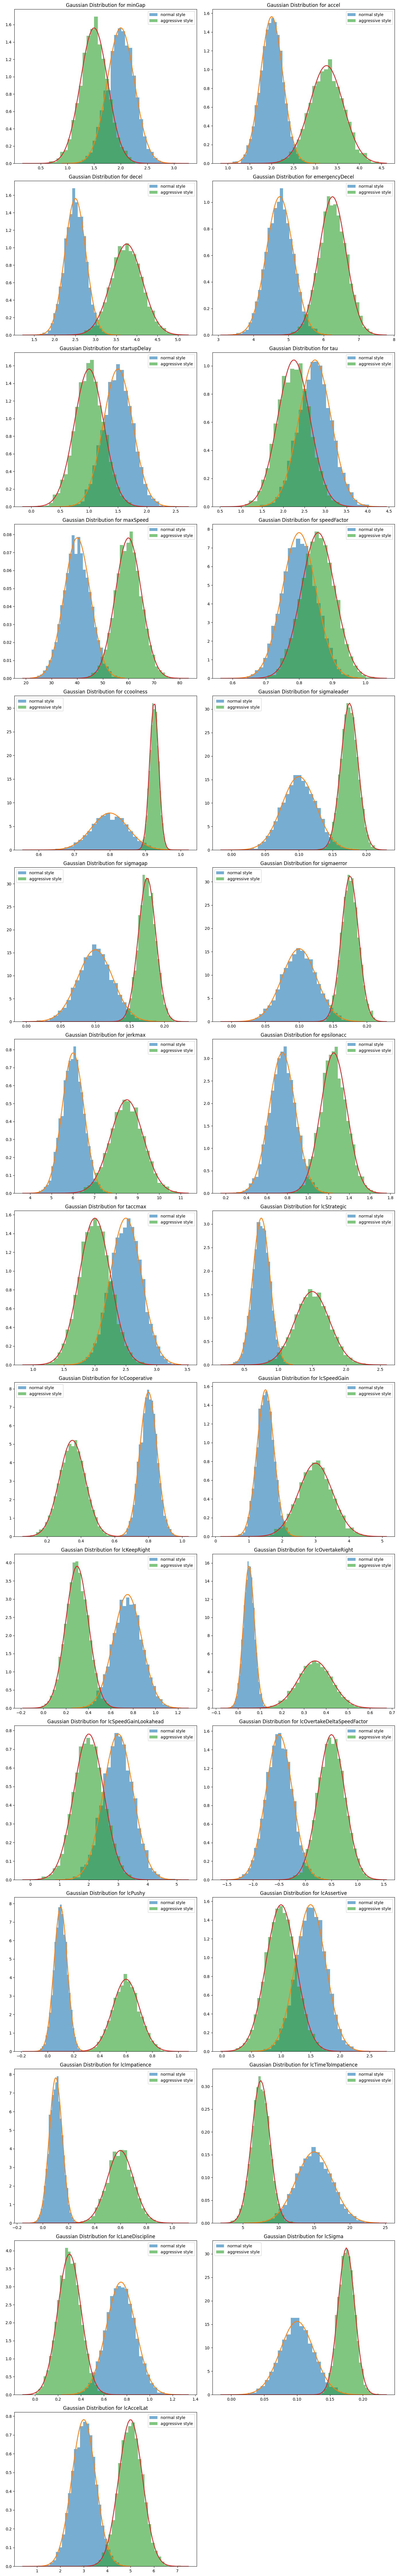

In [28]:
# Plot the distribution of the parameters for verification
importlib.reload(vehParameters)
vehParameters.showGaussianLLM(param_dict, [data['Parameter'][i] for i in range(len(data['Parameter']))], styles) 

In [100]:
# Setting the vehicle types for each student
n_vtypes = 5 # Number of vehicle types for each style
importlib.reload(vehParameters)
vehdists = vehParameters.generateVehicleTypesLLM(param_dict, styles, n_vtypes) # Generates the vehicle types for the vehicles
vehParameters.parseVehiclesXML(param_dict, vehdists, styles, FOLDER_NAME, car_follow_model="EIDM", lc_model="SL2015") # Parses the vehicles to the XML format and writes it to vTypesDistribution.xml

'<vTypeDistribution id="normal">\n\t<vType id="v_normal0" carFollowModel="EIDM" laneChangeModel="SL2015" minGap="3.11" accel="1.82" decel="2.93" emergencyDecel="5.04" startupDelay="1.28" tau="3.47" maxSpeed="79.71" speedFactor="0.85" ccoolness="0.54" sigmaleader="0.25" sigmagap="0.11" sigmaerror="0.14" jerkmax="6.52" epsilonacc="1.23" taccmax="1.03" lcStrategic="1.07" lcCooperative="0.88" lcSpeedGain="1.0" lcKeepRight="1.31" lcOvertakeRight="0.08" lcSpeedGainLookahead="3.82" lcOvertakeDeltaSpeedFactor="0.3" lcPushy="0.07" lcAssertive="1.92" lcImpatience="0.02" lcTimeToImpatience="19.45" lcLaneDiscipline="1.12" lcSigma="0.01" lcAccelLat="0.9" probability="0.06269674240407444">\n\t\t<param key="device.rerouting.probability" value="1.0"/>\n\t\t<param key="device.rerouting.adaptation-steps" value="18"/>\n\t\t<param key="device.rerouting.adaptation-interval" value="10"/>\n\t</vType>\n\t<vType id="v_normal1" carFollowModel="EIDM" laneChangeModel="SL2015" minGap="1.39" accel="2.51" decel="2.6

### Creating Random Trips to fill the simulation

Extracting the possible ids from the distribution to generate random trips

In [101]:
vtype_data = extract_vTypeDistribution(f"{FOLDER_NAME}/vTypesDistribution.xml")
vtype_data

{'normal': ['v_normal0', 'v_normal1', 'v_normal2', 'v_normal3', 'v_normal4'],
 'aggressive': ['v_aggressive0',
  'v_aggressive1',
  'v_aggressive2',
  'v_aggressive3',
  'v_aggressive4']}

In [125]:
rand_trips = None
final_trips_file_name = "finaltrips.rou.xml"

veh_style_per_student = ['veh_passenger'] * len(location_time_list) # Default vehicle style
# for i in range(len(location_time_list)):
#     veh_style_per_student.append(styles[i % len(styles)]) # Balacing the styles for the vehicles
type_ids_random = getRandomTrips(NET_PATH, ADDITONALS_PATH, end_time, vtype_data, departure_step=900) # Generates equally distributed random trips for each vehicle class
print(type_ids_random)

Success.
Success.
Generated 92 vehicles.
{'normal': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45'], 'aggressive': ['46', '47', '48', '50', '51', '52', '53', '54', '55', '56', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '87', '88', '89', '90', '91', '92', '93', '94', '95']}


In [126]:
departure_times = []
for i in range(len(location_time_list)):
    departure_times.append((list(location_time_list[i].keys())[0] - 7) * 20) # Departure times for each trip

In [127]:
# Merging the trips generated by the LLM with the random trips
steps_per_stop = 3600 # Number of steps in an hour
parseTripXML(location_time_list, parkingAreas, departure_times, veh_style_per_student, steps_per_stop=steps_per_stop, rand_trips=rand_trips, out_file_name=final_trips_file_name) 

### Getting Alternative Routes for each trip

In [128]:
## Arguments to get alternative routes
duaiterate_path = "/usr/share/sumo/tools/assign/duaIterate.py"
def duaiterate_getArgs(net_path, trips_path, additional_path, iterations):
    args = [
        "-n", net_path,
        "-t", trips_path,
        "--additional", additional_path,
        "duarouter--additional-files", additional_path,
        "-l", str(iterations),
    ]
    return args

In [129]:
def getAltRoutes(net_path, trips_path, additional_path, iterations):
    # Run the duarouter to find alternative routes
    # Currently this only works for less than 10 iterations because of file naming
    try:
        subprocess.run(['python3', duaiterate_path] + duaiterate_getArgs(net_path, f'{FOLDER_NAME}/{trips_path}', additional_path, iterations), check=True)
        file_name = trips_path.split('.')[0]

        shutil.move(f'00{iterations-1}/{file_name}_00{iterations-1}.rou.alt.xml', f'{FOLDER_NAME}/{file_name}.rou.alt.xml')
        
        for i in range(iterations):
            if os.path.exists(f'00{i}'):
                shutil.rmtree(f'00{i}')

        shutil.move('dua.log', f'{FOLDER_NAME}/dua.log')
        shutil.move('stdout.log', f'{FOLDER_NAME}/stdout.log')
        os.remove('edgedata.add.xml')

        trips_id = {}
        tree = ET.parse(f"{FOLDER_NAME}/{file_name}.rou.alt.xml")
        root = tree.getroot()
        vehicles = root.findall('vehicle')
        for i in range(len(vehicles)):
            cls = re.sub(r'\d+', '', vehicles[i].get('type').split('_', 1)[1]) # Extracts the class of the vehicle by removing numbers and the first part of the type

            if cls not in trips_id.keys():
                trips_id[cls] = []

            trips_id[cls].append(vehicles[i].get('id'))

        return trips_id
                
    except subprocess.CalledProcessError as e:
        print(f"{e}")

In [130]:
# This creates the {final_trips_file_name}.rou.alt.xml file
type_ids_routines = getAltRoutes(NET_PATH, final_trips_file_name, ADDITONALS_PATH, 1)
print(type_ids_routines)

> Executing step 0
>> Running router on unicamp/finaltrips.rou.xml
>>> Begin time: 2025-05-13 11:15:24.136923
>>> End time: 2025-05-13 11:15:24.483216
>>> Duration: 0:00:00.346293
<<
>> Running simulation
>>> Begin time: 2025-05-13 11:15:24.483279
>>> End time: 2025-05-13 11:15:25.300195
>>> Duration: 0:00:00.816916
<<
< Step 0 ended (duration: 0:00:01.163356)
------------------

dua-iterate ended (duration: 0:00:01.167618)
{'passenger': ['veh1']}


### Merging the trips and updating route files

If there is no need to generate alternative router for the random trips, the following XML parser must be used to add them:

In [131]:
def add_missing_vtypes(routes_file, types_file, output_file):
    # Parse the XML files
    routes_tree = ET.parse(routes_file)
    routes_root = routes_tree.getroot()
    types_tree = ET.parse(types_file)
    types_root = types_tree.getroot()
    
    # Extract existing vType IDs in routes_file
    existing_vtypes = {vtype.get('id') for vtype in routes_root.findall('vType')}
    
    # Find vTypes in types_file that are not in routes_file
    for vtype in types_root.findall(".//vType"):
        if vtype.get('id') not in existing_vtypes:
            routes_root.append(vtype)
    
    # Write the updated routes file
    routes_tree.write(output_file, encoding='utf-8', xml_declaration=True)
    print(f"Updated ROUTES_FILE saved as {output_file}")

In [132]:
def merge_routes(alternative_routes, random_routes, output_file_name = 'merged.rou.alt.xml'):
    # Merges two route files into one
    
    xml = '<routes xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:noNamespaceSchemaLocation="http://sumo.dlr.de/xsd/routes_file.xsd">\n'

    # Add missing vTypes to the alternative routes file
    add_missing_vtypes(alternative_routes, f'{FOLDER_NAME}/fixed_vTypeDistribution.xml', alternative_routes)

    xml += '\n<!-- BEGIN - LLM Generated trips -->\n'
    
    with open(alternative_routes, 'r') as f:
        start_read = False
        for line in f:
            test = line.strip()
            if test.startswith('<vType'):
                start_read = True
            if start_read:
                if line.startswith('</routes>'):
                    break
                xml += line

    xml += '\n\n <!-- END - LLM Generated trips -->\n\n'
    xml += '<!-- BEGIN - Random Trips -->\n\n'

    with open(random_routes, 'r') as f:
        start_read = False
        for line in f:
            test = line.strip()
            if not start_read and (test.startswith('<vType') or test.startswith('<vehicle')):
                start_read = True
            if start_read:
                xml += line

    xml += '<!-- END - Random Trips -->\n\n'

    with open(f'{FOLDER_NAME}/{output_file_name}', 'w') as f:
        f.write(xml)

    
    return xml    

In [133]:
# If alternative routes for random trips were ignored, the 'merged.rou.alt.xml' file will be created and should be used in osm.sumocfg
output_file_name = 'merged.rou.alt.xml'
if rand_trips == None:
    if os.path.exists(f'{FOLDER_NAME}/{output_file_name}'):
        os.remove(f'{FOLDER_NAME}/{output_file_name}')
    
    # If there are alternative routes, merge them
    if os.path.exists(f'{FOLDER_NAME}/finaltrips.rou.alt.xml'):
        merge_routes(f'{FOLDER_NAME}/finaltrips.rou.alt.xml', f'{FOLDER_NAME}/randtrips.rou.xml', output_file_name)

    # If alternative routes were found not generated, we are going to use the original ones
    else:
        merge_routes(f'{FOLDER_NAME}/finaltrips.rou.xml', f'{FOLDER_NAME}/randtrips.rou.xml', output_file_name)

Updated ROUTES_FILE saved as unicamp/finaltrips.rou.alt.xml


In [134]:
# Changing sumocfg to use the new route file
add_xml_child(SUMOCFG_PATH, 'input', 'route-files', output_file_name)
print("All done! The SUMO configuration file has been updated to use the new route file.")
print(f"You can now run the simulation inside the {FOLDER_NAME} folder using `sumo-gui osm.sumocfg` or generate the data using the `simulationData.ipynb` notebook.")

Child <route-files> with value 'merged.rou.alt.xml' already exists. Skipping addition.
All done! The SUMO configuration file has been updated to use the new route file.
You can now run the simulation inside the unicamp folder using `sumo-gui osm.sumocfg` or generate the data using the `simulationData.ipynb` notebook.


In [135]:
print("IDs for the vehicles that were generated with routines:")
print(type_ids_routines)
print("IDs for the vehicles that were generated with random trips:")
print(type_ids_random)

IDs for the vehicles that were generated with routines:
{'passenger': ['veh1']}
IDs for the vehicles that were generated with random trips:
{'normal': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45'], 'aggressive': ['46', '47', '48', '50', '51', '52', '53', '54', '55', '56', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '87', '88', '89', '90', '91', '92', '93', '94', '95']}


In [136]:
# Create the 'routines' folder if it doesn't exist
os.makedirs(f'{FOLDER_NAME}/routines', exist_ok=True)

# Save each dictionary in location_time_list as a CSV file
for idx, location_time in enumerate(location_time_list):
    df = pd.DataFrame.from_dict(location_time, orient='index')
    # Separate the coords tuple into latitude and longitude columns
    df[['latitude', 'longitude']] = pd.DataFrame(df['coords'].tolist(), index=df.index)
    df.drop(columns=['coords'], inplace=True)  # Drop the original coords column
    csv_path = f'{FOLDER_NAME}/routines/veh{idx + 1}.csv'
    df.to_csv(csv_path, index_label='Time')
    print(f"Route saved to: {csv_path}")

Route saved to: unicamp/routines/veh1.csv
